In [8]:
import sys
path_utils = '/decoding_toolbox_py/Helper_funcs' 
sys.path.append(path_utils)


In [9]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np

from mne import read_epochs
from mne.decoding import SlidingEstimator,GeneralizingEstimator

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVR, SVC
from decoding_toolbox_py.Helper_funcs.base_stats import corr_linear_circular

import mne
import os

#from jr.gat import subscore
#from jr.gat import AngularRegression, scorer_angle
#from jr.stats import corr_linear_circular
#from jr.plot import pretty_gat, pretty_decod

ModuleNotFoundError: No module named 'utils'

In [ ]:
EGG = True

subjs_list = ['s01'# , 's02'
              #, 's03' ,'s04','s05','s07','s08','s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' 
]
if EGG:
    path = 'Cond_CJ_EEG'
    all_epochs = []
    all_rawdata = [None] * np.size(subjs_list)
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
        subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
        all_rawdata[isubj] =  subj_data
        all_epochs.append(epoch);
        epoch.metadata
    all_st_epochs = []
    st_epochs = []
    all_st_rawdata = [None] * np.size(subjs_list)
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/mainstim_epo.fif',verbose=False)

        st_epochs.append(epoch.average()); 
        
        subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
        all_st_rawdata[isubj] =  subj_data
        all_st_epochs.append(epoch);
        epoch.metadata

        

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [ ]:
Y = all_st_rawdata[0]['epoch_dat']
X = np.array(all_st_rawdata[0]['metadata'].orient)
phi = X

In [ ]:
from base_stats import corr_linear_circular

def circ_corr_fun(Y, X):
    # Y is a matrix with trials x channels x timepoints
    # X is a vector with the orientation of each stimulus in radians
    n_trial, n_chan, n_time = Y.shape
    Yreshape = Y.reshape([-1, n_chan * n_time])
    # linear circular correlation between MEG and stim angle
    _, R2, _ = corr_linear_circular(Yreshape, X)
    R2 = R2.reshape([n_chan, n_time])
    return R2


In [ ]:
n_chan = 32
n_time = 201

In [ ]:

nSubj = np.size(subjs_list)
R_subjs = np.zeros((nSubj,n_time))
Rch_subjs = np.zeros((nSubj,n_chan, n_time))

for ival, isubj in enumerate(subjs_list):
    R2 = circ_corr_fun(all_st_rawdata[ival]['epoch_dat'], np.deg2rad(all_st_rawdata[ival]['metadata'].orient))
    R_subjs[ival, :] = np.squeeze(np.mean(R2,0))
    Rch_subjs[ival, :, :] = R2


Identifying common channels ...
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/x2/l6kq7w2s48bbjcgczm1ll_fm0000gn/T/ipykernel_7972/2507856631.py:1: RuntimeWarning: Only a single dataset was passed to mne.grand_average().
  st_gvaverage = mne.grand_average(st_epochs[:])


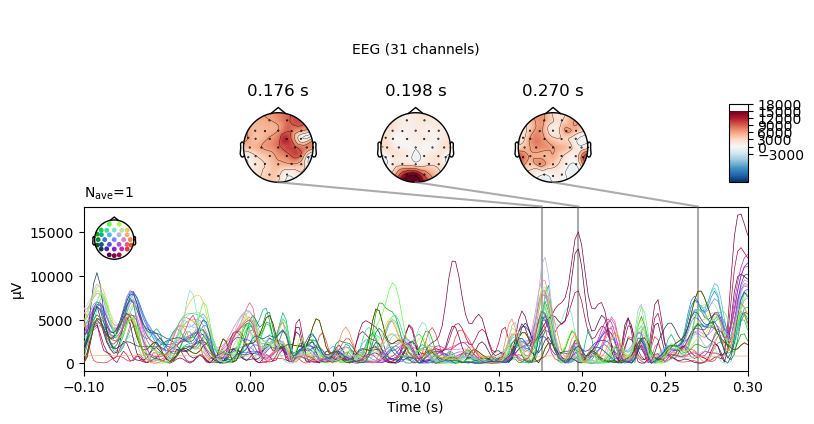

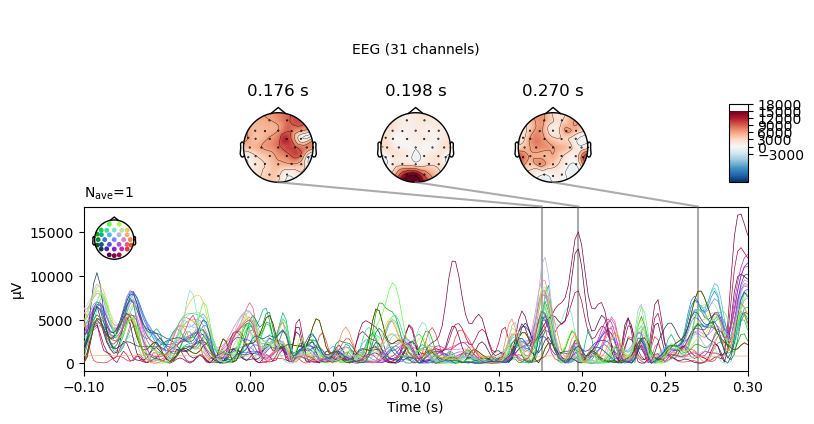

In [ ]:
st_gvaverage = mne.grand_average(st_epochs[:])
evoked = st_gvaverage.copy()
evoked.data = np.mean(Rch_subjs,axis = 0)
evoked.plot_joint()